# Today's topics
We will try to find out which phenotypic traits are associated with genetic markers in the BXD mouse population. This will allow us to make statements about the level of heritability of several traits and help us identify candidate genes responsible for specific traits.

There are several types of studies relevant in this context:

* Single gene association studies
* Genome wide association studies
* Phenome wide association studies

Today we'll perform a genome-wide association study. In particular, we will investigate which SNPs are associated with the coat color of mice.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load genotype data
To ensure that we all use the same input data, we provide the code you should load the genotype information with, just update the genotype tsv file's path to where you stored it on your system.

We split the table into metadata (`geno_meta`) and genotype data (`geno_BHD`) parts and index them with the `Locus` identifier.

In [2]:
# read genotype data
genotype = pd.read_csv("../example_data/aad0189_DataFileS4.txt", sep="\t", comment="@")
genotype.set_index("Locus", inplace=True)
geno_meta = genotype.iloc[:, :3]  # 3 because we had just moved the "Locus" column into the index
geno_bdh = genotype.iloc[:, 3:]

### Remove strains with a lot of missing genotype values
Before you convert the B/D/H/U labels to numeric, find the main culprits for the U (unknown) labels.
Only keep strains with less than 10 unknown loci and put them in `geno_bdh2`. Which strains did you have to remove?

In [3]:
# find strain less than 10 unknown loci (U) 
geno_bdh2 = geno_bdh.loc[:,geno_bdh.apply(pd.value_counts).fillna(0).loc['U'] < 10]
print("The strain I remove:")
print(geno_bdh.loc[:, geno_bdh.apply(pd.value_counts).fillna(0).loc['U'] >= 10].columns.to_list())

## another good way to go it.
geno_bdh2 = geno_bdh.loc[:, (geno_bdh == 'U').sum() < 10]

The strain I remove:
['BXD73b', 'BXD101', 'BXD102']


### Replace categorical genotype labels with numerical encoding

Unlike yesterday, we will use `{B: 0, H: 1, D: 2, U: 1}` encoding for the genotypes. Due to the previous step where we discarded strains with a lot of missing data, we have very few unknowns left, so it's acceptable to treat them as the intermediate heterozygous genotype instead of missing values. Call the numerical genotype dataframe `geno`.

In [4]:
geno = geno_bdh2.replace({'B': 0, 'H': 1, 'D': 2, 'U': 1})
geno.head()

,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,BXD14,...,BXD88,BXD89,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100
Locus,,,,,,,,,,,,,,,,,,,,,
rs6269442,0,0,2,2,2,0,0,2,0,0,...,2,0,0,2,0,2,2,0,0,0
rs6365999,0,0,2,2,2,0,0,2,0,0,...,2,0,0,2,0,2,2,0,0,0
rs6376963,0,0,2,2,2,0,0,2,0,0,...,2,0,0,2,0,2,2,0,0,0
rs3677817,0,0,2,2,2,0,0,2,0,0,...,2,0,0,2,0,2,2,0,0,0
rs8236463,0,0,2,2,2,0,2,2,0,0,...,2,0,0,2,0,2,2,0,0,0


## Download coat color information from genenetworks.org

Most mouse phenotype data is available at genenetwork.org. This includes nearly all published phenotype measurements. You can access individual measurements from that repository using the search mask:
1. Go to http://gn2.genenetwork.org/
2. In "Select and Search" fill in:
    1. Species: Mouse
    2. Group: BXD RI Family
    3. Type: Phenotypes
    4. Dataset: BXD Published Phenotypes
3. Enter the trait of interest in the "Get any" field
4. Search

For getting data on the coat color of BXD mice use "coat color" as search term and select the Record __11280__ to get to the corresponding __Trait Data and Analysis__ page. There you can export the data as a CSV file.

## Load coat color data

On the coat color data description page you saw that the colors had already been numerically encoded, so you don't have to convert it yourself. But keep an eye out for missing values and remove them. For future reference, the color encoding was:

|color  | value  |
|-------|--------|
| black |  4     |
| grey  |  3     |
| brown |  2     |
| dilute|  1     |

In [5]:
# load color file
colors = pd.read_csv('..\example_data\coat_color.csv', na_values='x', names=['strain', 'color']).set_index('strain').dropna()
colors

,color
strain,
C57BL/6J,4.0
DBA/2J,1.0
B6D2F1,4.0
D2B6F1,4.0
BXD1,1.0
...,...
BXD98,1.0
BXD99,1.0
BXD100,4.0


In [6]:
# add two column with 'C57BL/63' and 'DBA/23'
geno.insert(0, 'C57BL/6J', value=0)
geno.insert(0, 'DBA/2J', value=2)
geno

,DBA/2J,C57BL/6J,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,...,BXD88,BXD89,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100
Locus,,,,,,,,,,,,,,,,,,,,,
rs6269442,2,0,0,0,2,2,2,0,0,2,...,2,0,0,2,0,2,2,0,0,0
rs6365999,2,0,0,0,2,2,2,0,0,2,...,2,0,0,2,0,2,2,0,0,0
rs6376963,2,0,0,0,2,2,2,0,0,2,...,2,0,0,2,0,2,2,0,0,0
rs3677817,2,0,0,0,2,2,2,0,0,2,...,2,0,0,2,0,2,2,0,0,0
rs8236463,2,0,0,0,2,2,2,0,2,2,...,2,0,0,2,0,2,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEL-X_154259201,2,0,0,0,0,2,0,0,0,0,...,2,0,0,0,2,2,1,2,2,0
rs3657281,2,0,0,0,0,2,0,0,0,0,...,2,0,0,0,2,2,1,2,2,0
rs13484106,2,0,0,0,0,2,0,0,0,0,...,2,0,0,0,2,2,1,2,2,0


# Association tests between variants and categorical phenotype
We will first start testing SNPs for their association with a *categorical* phenotype, coat color. It is known to be heritable, and therefore genetically determined to a large extent, so we'll try to find candidate genes that could be involved. The fist step is finding the right SNPs.

## Task: Perfom association test for a single SNP using $\chi^2$ test

The chi2 test is a suitable test to detect association between two categorical random variables. It compares their observed combination counts with the combination counts that would be expected if there was no association between the two variables. The p-value calculated by the chi2 test is a measure of how likely it is for the expected and actual combination counts to differ as much as they do by mere chance.

In [7]:
# find the intersection part bewteen colors and genotype
usable_strains = colors.index.intersection(geno.columns)
colors = colors.loc[usable_strains]
geno = geno.loc[:, usable_strains]

### Extract the genotype information for a single SNP
It can be any SNP, but make sure you don't hardcode it! Put the locus identifier string into the `snp` variable.

In [8]:
snp = 'rs6232550'

In [9]:
one_geno = geno.loc[snp]

### Combine SNP data with phenotype data

Create a DataFrame with two columns: one for the color, one for the genotype. We aren't interested in unknown values, remember the "inner join".

In [10]:
### not working here
one_geno

C57BL/6J    0
DBA/2J      2
BXD1        2
BXD2        0
BXD5        0
           ..
BXD94       2
BXD95       0
BXD98       2
BXD99       2
BXD100      2
Name: rs6232550, Length: 89, dtype: int64

### Plot relationship between genotye and phenotype

You can use a scatter plot, but equal values will occlude each other, so you should add some jitter (small random noise). You can achieve this by generating random values in the same shape as your ~DataFrame~ two series, and adding it.

You can also try a heatmap, but make sure your color range starts from zero.

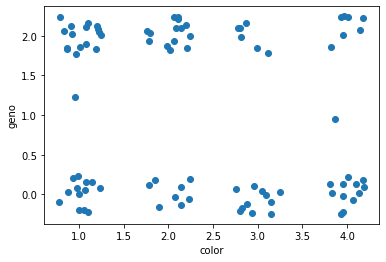

In [11]:
# add noise with x and y label
noise1 = 0.5*np.random.random(one_geno.shape) - 0.25
noise2 = 0.5*np.random.random(one_geno.shape) - 0.25

# plot scatter plot showing cluster
plt.scatter(colors['color']+noise1, one_geno+noise2)
plt.xlabel('color')
plt.ylabel('geno')
plt.show()

### Create a contingency table for a D-dominant inheritance model of black coat color for your SNP

What does D-dominant mean here, how should you treat the heterozygous genotype? Think about the individual cells of the contingency matrix: it has a 2x2 shape, but you have 3 kinds of genotypes and 4 kinds of colors. How should you collapse your data to binary labels?

Tip: Pandas' `crosstab` functionality may be helpful for you.

In [12]:
# find D dominant and calculate cross table
colors2 = colors['color']
pd.crosstab((colors['color'] == 4), (one_geno >= 1))

rs6232550,False,True
color,,
False,32,37
True,12,8


### Perform a $\chi^2$ square test for independence on the contingency table

Find a suitable method in `scipy.stats` and read its documentation to understand what the returned values are. How can you access the test's p-value?

In [13]:
# Using chi2 to calculate x square
import scipy.stats as stats
pval = stats.chi2_contingency(pd.crosstab((colors['color'] == 4), (one_geno >= 1)))[1]
pval

0.4127962429654475

## Refactor the previous analysis steps into a function and apply to all SNPs

Try to do it without writing any `for` loops. Use the built-in iterating functionality that pandas provides with the `apply` method.

If you are ahead of schedule, you could try to come up with a faster approach. Doing 3811 cross-tabulations from scratch might be a bit wasteful, since the coat color labels are constant in every iteration. It is possible to calculate all 3811 contingency table values with a few simple operations, and therefore run all chi2 tests in a matter of seconds instead of a minute.

But speed doesn't really matter for us now. Whichever way you do it, answer the following question:

How many SNPs are associated with coat color at a p<0.05 significance threshold?

In [14]:
def chi2_geno_coat(locus):
    p_value = stats.chi2_contingency(pd.crosstab((colors2 == 4), (locus >= 1)))[1]
    return p_value

In [15]:
pvals = geno.apply(chi2_geno_coat, axis=1)

In [16]:
(pvals < 0.05).sum()

253

### Add the p-values to the SNP metadata (`geno_meta`) DataFrame

Insert them as a new column called `p_raw`.

In [17]:
geno_meta = genotype.iloc[:, :3]
geno_meta.insert(0, column='p value', value=pvals)

In [18]:
geno_meta

,p value,Chr,cM,Mb
Locus,,,,
rs6269442,0.012001,1,0.000,3.482275
rs6365999,0.012001,1,0.000,4.811062
rs6376963,0.058495,1,0.895,5.008089
rs3677817,0.074896,1,1.185,5.176058
rs8236463,0.246533,1,2.081,5.579193
...,...,...,...,...
CEL-X_154259201,0.180213,X,71.490,160.727278
rs3657281,0.349773,X,71.776,160.951099
rs13484106,0.349773,X,71.776,162.637897


### Create a Manhattan Plot of  $-\log_{10}(\text{P-value})$ vs chromosome position 
A Manhattan plot, named after its resemblance to the skyline of Manhattan, is commonly used to plot the p-values of SNP association tests against their genomic position.

Technically, it's a scatter plot of genome position vs the negative base-10 logarithm of the p-value (~how many zeroes does the p-value begin with). Try to recreate something like the plot below. It doesn't have to be an exact match, but at least the chromosomes should be distinguishable.

Think about how to convert chromosome number + Mb position within the chromosome into a single absolute position on the x-axis.

<img src='Manhattan.png'>

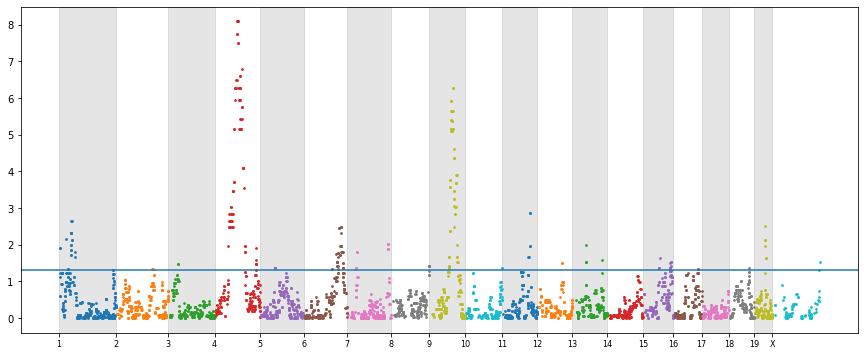

In [20]:
## Better way to do
plt.figure(figsize=(15,6))
x_position = []
x_label = []
position = 0
for label, data in geno_meta.groupby("Chr", sort=False):
    x_position.append(position)
    x_label.append(label)
    plt.scatter(data['Mb']+position, -np.log10(data['p value']),s=3, zorder=2)
    position+=data['Mb'].max()
    
for x1, x2 in zip(x_position[::2], x_position[1::2]):
    plt.axvspan(x1, x2, color='black', alpha=0.1, zorder=1)
plt.axhline(-np.log10(0.05))
plt.xticks(x_position, x_label, fontsize=8)
plt.show()

## Task: Correction for Multiple Hypothesis Testing

### Preliminary task: p-value histograms

Plot a histogram of all the p-values that you got from the $\chi^2$ tests. Generate the same amount of random uniformly distributed values between [0,1], and put them on the same histogram for a baseline comparison. (Remember, a chi2 test, or any well-calibrated statistical test would always produce a uniform distribution if there was no association between two random variables.)

Will any of our p-values survive multiple testing correction in your opinion? If so, guess how many! If necessary, increase the number of bins to capture the differences between the two histograms near p=0.

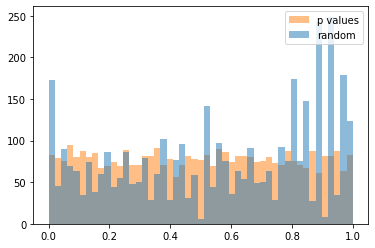

In [21]:
# plot histogram
bins = np.linspace(0,1,50)
unit = np.random.uniform(0,1, len(pvals))
plt.hist((pvals, unit), bins=bins, histtype='stepfilled', alpha=0.5)
plt.legend(['p values', 'random'])

### Use the Benjamini-Hochberg correction method to take care of the multiple hypothesis testing problem

Insert the B-H corrected p-values into the locus information DataFrame `geno_meta` as a new column named `p_bh`.

After the Benjamini-Hochberg correction, how many SNPs stayed significantly associated with coat color at the p<0.05 level? Compare this number with your earlier guess based on the raw p-value histogram. (And perhaps ponder: have we *really* tested 3811 different association hypotheses?)

In [22]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [23]:
# using BH for correct p values
BH_pval = multipletests(geno_meta['p value'], method='fdr_bh' )[1]
geno_meta['p_bh'] = BH_pval

In [24]:
geno_meta

,p value,Chr,cM,Mb,p_bh
Locus,,,,,
rs6269442,0.012001,1,0.000,3.482275,0.298921
rs6365999,0.012001,1,0.000,4.811062,0.298921
rs6376963,0.058495,1,0.895,5.008089,0.727488
rs3677817,0.074896,1,1.185,5.176058,0.786301
rs8236463,0.246533,1,2.081,5.579193,0.988040
...,...,...,...,...,...
CEL-X_154259201,0.180213,X,71.490,160.727278,0.988040
rs3657281,0.349773,X,71.776,160.951099,0.988040
rs13484106,0.349773,X,71.776,162.637897,0.988040


### Plot a histogram of the corrected p-values

Compare it with the original histogram of raw p-values. Does it match your expectations?

If you want, you can also try to recreate the Manhattan plot with the corrected p-values this time.

89

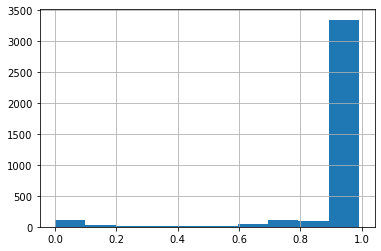

In [25]:
geno_meta['p_bh'].hist()
(geno_meta['p_bh'] < 0.05).sum()

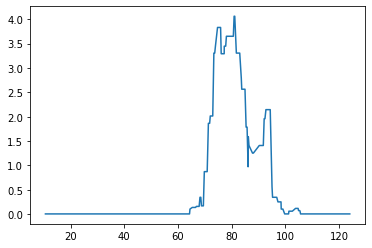

In [26]:
geno_meta['log_p_bh'] = -np.log10(BH_pval)
x = geno_meta.loc[geno_meta['Chr'] == '9']['Mb']
y = geno_meta.loc[geno_meta['Chr'] == '9']['log_p_bh']
plt.plot(x, y)

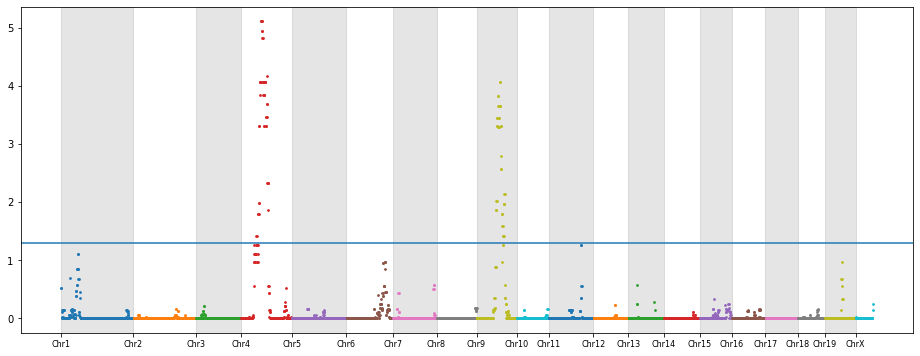

In [27]:
plt.figure(figsize=(16,6))
x_position = []
x_label = []
position = 0

for label, data in geno_meta.reset_index('Locus').groupby("Chr", sort=False):
    x_position.append(position)
    x_label.append('Chr'+label)
    plt.scatter(data.index, -np.log10(data['p_bh']),s=3, zorder=2)
    position=data.index.max()
    
for x1, x2 in zip(x_position[::2], x_position[1::2]):
    plt.axvspan(x1, x2, color='black', alpha=0.1, zorder=1)
plt.axhline(-np.log10(0.05))
plt.xticks(x_position, x_label, fontsize=8)
plt.show()

### Check if the genes you found match the literature about genetics of mouse coat color 

Hint / spoiler: ([PMC2736153](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2736153)).

Extra task not in notebook: jitterplot of the best chr4 and chr9 SNPs

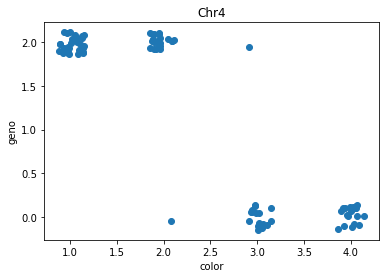

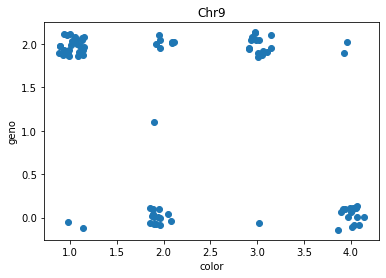

In [28]:
noise1 = 0.3*np.random.random(one_geno.shape) - 0.15
noise2 = 0.3*np.random.random(one_geno.shape) - 0.15
chrs = ['4','9']
locuss = []
for c in chrs:
    max_locus = geno_meta.loc[(geno_meta['Chr'] == c)]['log_p_bh'].idxmax()
    best_gene = geno.loc[max_locus]
    
    plt.scatter(colors2+noise1, best_gene+noise2)
    plt.title('Chr%s' %(c))
    plt.xlabel('color')
    plt.ylabel('geno')
    plt.show()